### Imports

In [144]:
import os
import sys
import random
import time

import numpy as np
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf
from svetlanna.transforms import ToWavefront

# datasets of wavefronts
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [145]:
import GPUtil
import cpuinfo
import psutil

In [146]:
# Получение информации о GPU
def get_gpu_info():
    gpus = GPUtil.getGPUs()
    gpu_info = []
    for gpu in gpus:
        info = {
            "id": gpu.id,
            "name": gpu.name,
            "load": gpu.load,
            "free_memory": gpu.memoryFree,
            "used_memory": gpu.memoryUsed,
            "total_memory": gpu.memoryTotal,
            "temperature": gpu.temperature,
            "uuid": gpu.uuid
        }
        gpu_info.append(info)
    return gpu_info

# Вывод информации о GPU
gpu_info = get_gpu_info()
print("GPU Information:")
for info in gpu_info:
    for key, value in info.items():
        print(f"{key}: {value}")
    print("-" * 20)

GPU Information:
id: 0
name: NVIDIA GeForce GTX 1050
load: 0.0
free_memory: 3436.0
used_memory: 569.0
total_memory: 4096.0
temperature: 46.0
uuid: GPU-a013ac1c-c861-d8ac-4b46-e3eaa68461f1
--------------------


# Optical Neural Network

In that example notebook we will try to realize a simple architecture of an optical system, which might be used for the optical neural network.

> In general, the phase and amplitude of eachneuron can be learnable parameters, providinga complex-valued modulation at each layer, which improves the inference performance of the diffractive network.

> ... we first trained it as a digit classifierto perform automated classification of hand-written digits, from $0$ to $9$. Forthis task, phase-only transmission masks were designed by training **a five-layer** $D^2 NN$ with $55,000$ images ($5000$ validation images) from the MNIST handwritten digit data-base.

>  We then used continuous-wave illumination at $0.4$ $THz$...

Some info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (information about MNIST classification):

> Because we consider coherent illumination, the input information can be encoded in the amplitude and/or phase channels of the input plane.

> For each layer of the $D^2NN$, we set we set the neuron size to be $400$ $\mu m$...

> At the detector/output plane, we measured the intensity of the network output...

#### <span style="color:red">Additional information</span>

In another article [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) of the same authors sume details were clarified: 

> In our numerical simulations, we used a neuron size of approximately $0.53 \times \lambda $

>  In addition, the height and width of each diffractive layer was set to include $200 \times 200 = 40K$ neurons per layer.

# 1. Simulation parameters

In [147]:
working_frequency = 0.4 * 1e12 # [Hz]
c_const = 299_792_458  # [m / s]

In [148]:
working_wavelength = c_const / working_frequency  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [149]:
# neuron size (square)
neuron_size = 0.53 * working_wavelength  # [m]
print(f'neuron size = {neuron_size * 1e6:.3f} um')

neuron size = 397.225 um


In [150]:
DETECTOR_SIZE = (256, 256)  # from the extended article!
# an actual zone where weights will be updated during a training process

**<span style="color:red">Difference.</span>** We will use `'AS'` method for `FreeSpace`'s, but we wont increase a size of a layer in `SimulationParameters` (i.e. numerical mesh)!

In [151]:
# number of neurons in simulation
x_layer_nodes = DETECTOR_SIZE[1] * 1
y_layer_nodes = DETECTOR_SIZE[0] * 1
# Comment: Same size as proposed!

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 256 x 256 = 65536


In [152]:
# physical size of each layer (from the article) - (8 x 8) [cm]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in cm): {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

Layer size (in cm): 10.16896017536 x 10.16896017536


In [153]:
# simulation parameters for the rest of the notebook
SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation (Data Engineer)

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [154]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

### 2.1.1. Load Train and Test datasets of images

In [155]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=False,
)

In [156]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=False,
)

In [157]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Create Train and Test datasets of wavefronts

We need to do an amplitude modulation of each image from the dataset.

#### Select classes zones on `Detector`

> ... size of these detectors $(6.4 \lambda \times 6.4 \lambda)$ ...

**<span style="color:red">Comment:</span>** `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

In [158]:
import src.detector_segmentation as detector_segmentation

In [159]:
number_of_classes = 10

#### Detector mask

In [160]:
detector_segment_size = 10 * working_wavelength

In [161]:
# size of each segment in neurons
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# each segment of size = (y_segment_nodes, x_segment_nodes)

In [162]:
y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9

In [163]:
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # size of a detector or an aperture (in the middle of detector)
    SIM_PARAMS
)

**<span style="color:red">Comment:</span>** This mask will be used to generate a target image for each number! 

<span style="color:red">Target image:</span> zeros are everywhere except the necessary zone responsible for the label! 

#### To visualize detector zones (for further use)

In [164]:
ZONES_HIGHLIGHT_COLOR = 'r'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_MASK.clone().detach()

In [165]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    delta = 1 #0.5

    for ind_class in range(number_of_classes):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)

        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta),
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta,
            linewidth=ZONES_LW,
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )

        zones_patches.append(zone_rect)

    return zones_patches

#### Visualize mask

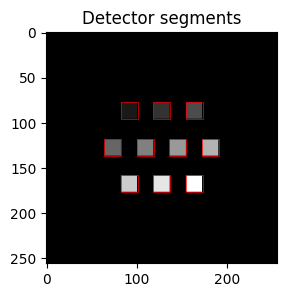

In [166]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(selected_detector_mask, cmap='grey')

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax0.add_patch(zone)

plt.show()

#### Dataset of wavefronts

In [167]:
# select modulation type
MODULATION_TYPE = 'amp'  # using ONLY amplitude to encode each picture in a Wavefront!

In [168]:
resize_y = int(DETECTOR_SIZE[0] / 3)
resize_x = int(DETECTOR_SIZE[1] / 3)  # shape for transforms.Resize
# Comment: Looks like in [2] article MNIST pictures were resized to ~100 x 100 neurons

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [169]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]
)

**<span style="color:red">Comment.</span>** Here `dataset.getitem()` will return a pair of a `Wavefront`, where a number encoded, and a target label (a number from 0 to 9). During the training process we will use MSE loss and we will generate a target detector picture based on a detector zones (will be initialized later in 3.1.3). 

In [170]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [171]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [172]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


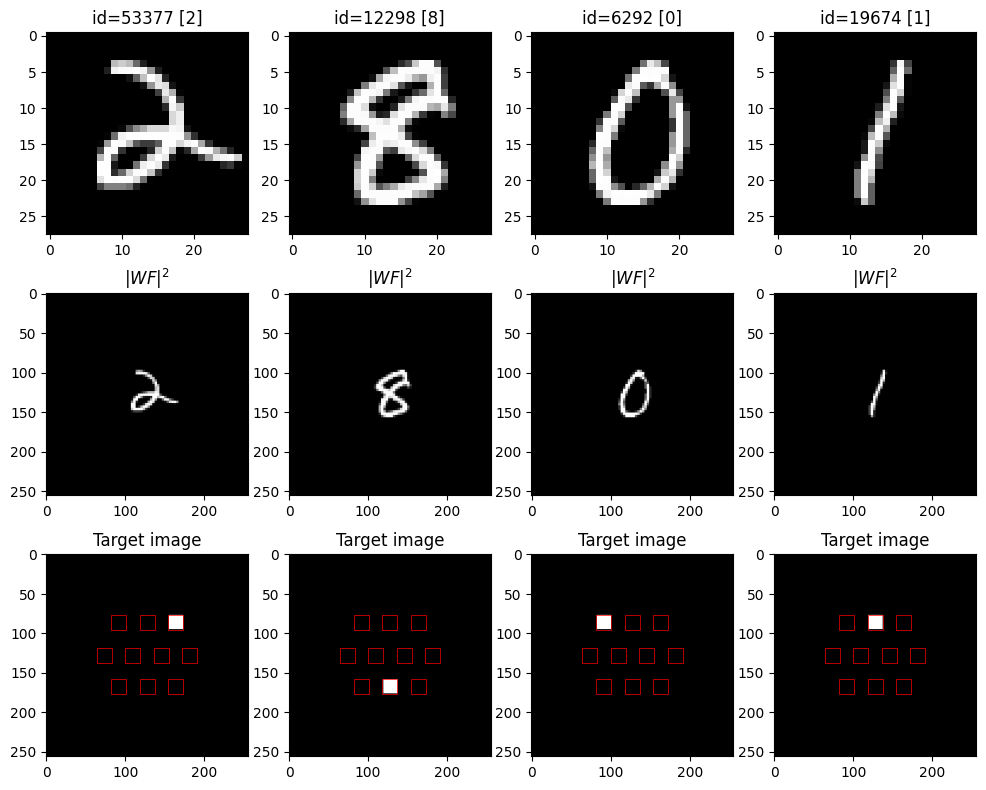

In [173]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]

    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, target_image = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )

    # axs[2][ind_ex].set_title(f'phase of $WF$')
    # axs[2][ind_ex].imshow(
    #     wavefront.phase[0], cmap='gray',
    #     vmin=0, vmax= 2 * torch.pi
    # )

    axs[2][ind_ex].set_title(f'Target image')
    axs[2][ind_ex].imshow(
        target_image, cmap='gray',
        vmin=0, vmax= 1
    )

    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        axs[2][ind_ex].add_patch(zone)

plt.show()

# 3. Optical network

Info from a supplementary material of [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> Following the corresponding $D^2NN$ design, the axial distance between two successive 3D-printed layers was set to be $3.0$ $cm$...

> The distance between detector/output plane and the last layer of the optical neural network was adjusted as $3$ $cm$...

#### <span style="color:red">Additional information</span>

From [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> ... the axial distance between the successive diffractive layers is set to be $\sim 40 \times \lambda$ as in [[1]](https://www.science.org/doi/10.1126/science.aat8084) ...

**<span style="color:red">Difference.</span>** You can use an another number of diffractive layers (for phase-only training)!

In [174]:
NUM_OF_DIFF_LAYERS = 5  # number of diffractive layers
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [m] - distance between difractive layers

In [175]:
print(f'Distance between layers is {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Distance between layers is 2.998 cm


## 3.1. Architecture

See Figure 2A from [[1]](https://www.science.org/doi/10.1126/science.aat8084).

See Figure 1(a) from [[2]](https://ieeexplore.ieee.org/abstract/document/8732486).

### 3.1.1. List of Elements

In [176]:
MAX_PHASE = 2 * np.pi  # max phase for phase masks

**<span style="color:red">Information from [1,2]: </span>**
> a $5$-layer, phase-only (complex-valued) diffractive optical network ...

**<span style="color:red">Difference.</span>** An another method for `FreeSpace`'s in contrast to [2]!

In [177]:
FREESPACE_METHOD = 'AS'  # we use another method in contrast to [2]!!!

**<span style="color:red">Information from [2]: </span>**
> a diffractive layer ... neurons ... were initialized with $\pi$ for phase values and $1$ for amplitude values ...

In [178]:
INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi  # initial values for phase masks

**<span style="color:red">Comment</span>**

Here we are using a default `ConstrainedParameter` which is using the sigmoid function to limit a parameter range.

In [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) authors discuss such approach in the section Results and Discussion A. and underline that limiting parameters with the sigmoid function may lead to Vanishing Gradients. Authors also propose an another way to limit parameters - by using ReLU.

In our case the sigmoid function works well but it is possible to realize the ReLU approach via specifying `bound_func` for `Constrained Parameter` (<span style="color:red">examples of customizing `bound_func` are provided in ...</span>).

In [179]:
# functions that return single elements for further architecture

def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value

    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!

In [180]:
def get_const_phase_layer_no_train(
    sim_params: SimulationParameters,
    value
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value

    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=const_mask,  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!

Function to construct a list of elements to reproduce an architecture from [the extended article](https://ieeexplore.ieee.org/abstract/document/8732486):

In [181]:
def get_elements_list(
    num_layers,
    num_layers_no_train,
    simulation_parameters,
    freespace_method,
    phase_values,
):
    """
    Composes a list of elements for the setup.
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    phase_values : torch.Tensor()
        Torch tensor of phase values to generate constant masks for diffractive layers.

    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements

    # first FreeSpace layer before first DiffractiveLayer
    elements_list.append(
        get_free_space(
            simulation_parameters,  # simulation parameters for the notebook
            FREE_SPACE_DISTANCE,  # in [m]
            freespace_method=freespace_method,
        )
    )

    # compose the architecture
    for ind_layer in range(num_layers):

        # -----------------------------------------------------------------------
        # add DiffractiveLayer (learnable phase mask)
        elements_list.append(
            get_const_phase_layer(
                simulation_parameters,  # simulation parameters for the notebook
                value=phase_values[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # -----------------------------------------------------------------------

        # add FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )

    for ind_layer in range(num_layers_no_train):

        # -----------------------------------------------------------------------
        # add DiffractiveLayer (untrained phase mask)
        elements_list.append(
            get_const_phase_layer_no_train(
                simulation_parameters,  # simulation parameters for the notebook
                value=phase_values[(ind_layer % (num_layers))].item()
            )
        )
        # -----------------------------------------------------------------------

        # add FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )

    # ---------------------------------------------------------------------------
    # add Detector in the end of the system!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )

    return elements_list

In [182]:
def get_elements_list_fs(
    simulation_parameters,
    freespace_method,
    num_of_fs: int
):
    elements_list = []
    for _ in range(num_of_fs):
        elements_list.append(
        get_free_space(
            simulation_parameters,  # simulation parameters for the notebook
            FREE_SPACE_DISTANCE,  # in [m]
            freespace_method=freespace_method,
        )
    )

    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )
    return elements_list

In [183]:
def get_elements_list_dl(
    simulation_parameters,
    phase_values,
    num_of_dl: int
):
    elements_list = []
    for ind_layer in range(num_of_dl):
        elements_list.append(
            get_const_phase_layer_no_train(
                simulation_parameters,  # simulation parameters for the notebook
                value=1.
            )
        )


    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )
    return elements_list

In [184]:
NUM_OF_DIFF_LAYERS_NO_TRAIN = 507

In [185]:
architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    num_layers_no_train=NUM_OF_DIFF_LAYERS_NO_TRAIN,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    phase_values=INIT_PHASES,
)

print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 1026


### 3.1.2. Compose `LinearOpticalSetup`

In [186]:
def get_setup(simulation_parameters):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        num_layers_no_train=NUM_OF_DIFF_LAYERS_NO_TRAIN,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        phase_values=INIT_PHASES,
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [187]:
def get_setup_upd(num_layers_no_train):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        num_layers_no_train=num_layers_no_train,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        phase_values=INIT_PHASES,
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [188]:
def get_setup_fs(num_of_fs):

    elements_list = get_elements_list_fs(
        simulation_parameters=SIM_PARAMS,
        freespace_method="AS",
        num_of_fs=num_of_fs
    )
    return LinearOpticalSetup(elements=elements_list)

In [189]:
def get_setup_dl(num_of_dl):
    elements_list = get_elements_list_dl(
        simulation_parameters=SIM_PARAMS,
        phase_values=INIT_PHASES,
        num_of_dl=num_of_dl
    )
    return LinearOpticalSetup(elements=elements_list)

In [190]:
# create an optical setup
optical_setup = get_setup_upd(NUM_OF_DIFF_LAYERS_NO_TRAIN)

**<span style="color:red">Comment:</span>** Setup ends with `Detector` that returns an output tensor of intensities for each input `Wavefront`.

#### Example of a wavefrnt propagation

In [191]:
example_wf = mnist_wf_train_ds[128][0]

In [192]:
setup_scheme, wavefronts = optical_setup.stepwise_forward(example_wf)

### 3.1.3 Detector processor (to calculate accuracies only)

> ... size of these detectors $(6.4 \lambda \times 6.4 \lambda)$ ...

**<span style="color:red">Comment:</span>** `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

In [193]:
CALCULATE_ACCURACIES = True  # if False, accuracies will not be calculated!

In [194]:
# create a DetectorProcessorOzcanClf object
if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=number_of_classes,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

# 4. Training of the network

Variables at the moment
- `lin_optical_setup` : `LinearOpticalSetup` – a linear optical network composed of Elements
- `detector_processor` : `DetectorProcessorClf` – this layer process an image from the detector and calculates probabilities of belonging to classes.

In [195]:
DEVICE = 'cuda'  # 'mps' is not support a CrossEntropyLoss

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

Info from a supplementary material of [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> The training batch size was set to be $8$...

In [196]:
train_bs = 128  # a batch size for training set
val_bs = 64

> Forthis task, phase-only transmission masks weredesigned by training a five-layer $D^2 NN$ with $55000$ images ($5000$ validation images) from theMNIST (Modified National Institute of Stan-dards and Technology) handwritten digit data-base.

In [197]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(178)  # for reproducibility
)

In [198]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Info from a supplementary material of [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> We used the stochastic gradient descent algorithm, Adam, to back-propagate the errors and update the
layers of the network to minimize the loss function.

**<span style="color:red">Additional info</span>** from [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):
> a back-propagation method by applying the adaptive moment estimation optimizer (Adam) with a learning rate of $10^{−3}$

In [199]:
LR = 1e-3

In [200]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

**<span style="color:red">Comment:</span>** We are using `MSELoss` as in [1] (that was clarified in [2])! 

In [201]:
loss_func_clf = nn.MSELoss()  # by default: reduction='mean'
loss_func_name = 'MSE'

## 4.2. Training of the optical network

### 4.2.1. Before training

> a diffractive layer ... neurons ... were initialized with $\pi$ for phase values and $1$ for amplitude values ...

#### Metrics for Test dataset

In [202]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

In [203]:
optical_setup.net = optical_setup.net.to(DEVICE)
SIM_PARAMS = SIM_PARAMS.to(DEVICE)

## 4.3. Forward Loop

In [204]:
def onn_forward(
    optical_net,
    wavefronts_dataloader,
    device='cpu',
    show_process=False
    ):
    """
    Performs network's forward for all data.
        NO DetectorProcessor
        NO Loss
    """
    optical_net.eval()  # activate 'eval' mode of a model

    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]

        # Pin memory for faster transfer to GPU
        batch_wavefronts = batch_wavefronts.pin_memory().to(device, non_blocking=True)
        batch_labels = batch_labels.pin_memory().to(device, non_blocking=True)

        with torch.no_grad():
            # ONLY FORWARD!
            detector_output  = optical_net(batch_wavefronts)

## 4.4. DEVICE = GPU

In [205]:
DEVICE = "cuda"

In [206]:
optical_setup.net = optical_setup.net.to(DEVICE)
SIM_PARAMS = SIM_PARAMS.to(DEVICE)

PROFILING WITH CHOOSEN DEVICE

In [207]:
# # speed test just for forward on train set
# with Profile() as profile:
#     onn_forward(
#         optical_setup.net,  # optical network composed in 3.
#         train_wf_loader,  # dataloader of training set
#         device=DEVICE,
#         show_process=True,
#     )
#     Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(30)

In [208]:
batch_sizes = [32, 64, 256, 512]

In [209]:
params = [
    {
        'pin_memory': True,
        'drop_last': True,
    },
]

# cpu_times = {}
gpu_times = {}

for i, param in enumerate(params):
    # cpu_times_ = []
    gpu_times_ = []

    # cpu_times[i] = cpu_times_
    gpu_times[i] = gpu_times_

    for bs in batch_sizes:
        train_loader = torch.utils.data.DataLoader(
            train_wf_ds,
            batch_size=bs,
            **param

        )

        SIM_PARAMS = SIM_PARAMS.to('cuda')

        # optical_setup = get_setup_upd(2)
        # optical_setup = get_setup_fs(7)
        optical_setup = get_setup_dl(7)

        net = optical_setup.net.to('cuda')
        start = time.process_time()
        onn_forward(
            net,  # optical network composed in 3.
            train_loader,  # dataloader of training set
            device='cuda',
            show_process=True,
        )
        gpu_times_.append(time.process_time() - start)
        torch.cuda.empty_cache()

validation:   0%|          | 0/1718 [00:00<?, ?it/s]

validation: 100%|██████████| 107/107 [01:40<00:00,  1.06it/s]


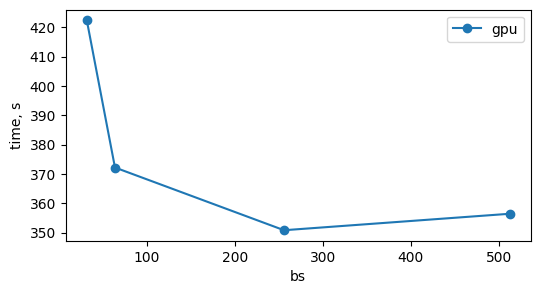

In [210]:
plt.figure(figsize=(6, 3))
# plt.plot(batch_sizes, cpu_times[0], '-o', label='cpu')
plt.plot(batch_sizes, gpu_times[0], '-o', label='gpu')
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('bs')
plt.ylabel('time, s')
plt.legend()

## 4.5. DEVICE = CPU

In [211]:
DEVICE = "cpu"
optical_setup.net = optical_setup.net.to(DEVICE)
SIM_PARAMS = SIM_PARAMS.to(DEVICE)

In [212]:
# speed test just for forward on train set
# with Profile() as profile:
#     onn_forward(
#         optical_setup.net,  # optical network composed in 3.
#         train_wf_loader,  # dataloader of training set
#         device=DEVICE,
#         show_process=True,
#     )
#     Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(30)

In [213]:
params = [
    {
        'pin_memory': True,
        'drop_last': True,
    },
]

cpu_times = {}

for i, param in enumerate(params):
    cpu_times_ = []
    # gpu_times_ = []

    cpu_times[i] = cpu_times_
    # gpu_times[i] = gpu_times_

    for bs in batch_sizes:
        train_loader = torch.utils.data.DataLoader(
            train_wf_ds,
            batch_size=bs,
            **param

        )

        SIM_PARAMS = SIM_PARAMS.to('cpu')

        # optical_setup = get_setup_upd(2)
        # optical_setup = get_setup_fs(7)
        optical_setup = get_setup_dl(7)


        net = optical_setup.net.to('cpu')
        start = time.process_time()
        onn_forward(
            net,  # optical network composed in 3.
            train_loader,  # dataloader of training set
            device='cpu',
            show_process=True,
        )
        cpu_times_.append(time.process_time() - start)

validation: 100%|██████████| 107/107 [03:07<00:00,  1.76s/it]


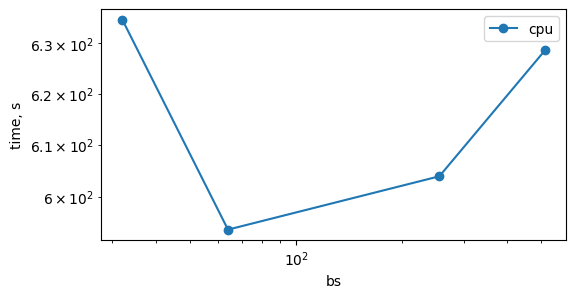

In [214]:
plt.figure(figsize=(6, 3))
plt.plot(batch_sizes, cpu_times[0], '-o', label='cpu')
# plt.plot(batch_sizes, gpu_times[0], '-o', label='gpu')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('bs')
plt.ylabel('time, s')
plt.legend()

## 4.6 COMPARING CPU AND GPU

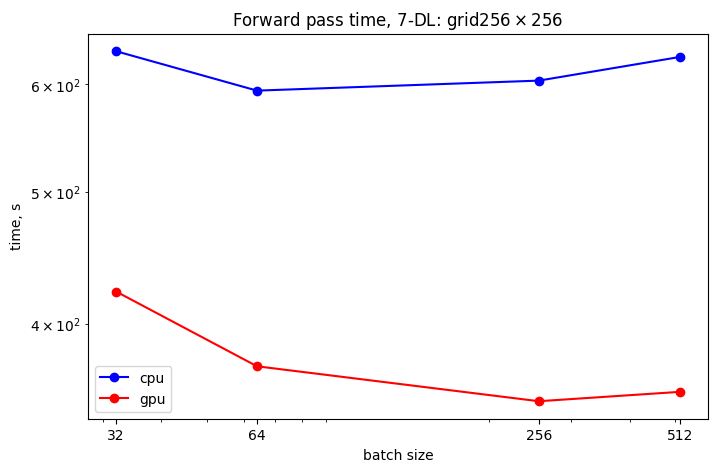

In [215]:
plt.figure(figsize=(8, 5))
plt.title('Forward pass time, 7-DL: grid' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
plt.plot(batch_sizes, cpu_times[0], '-o', label='cpu', color="blue")
plt.plot(batch_sizes, gpu_times[0], '-o', label='gpu', color="red")
plt.yscale('log')
plt.xscale('log')
plt.xticks(batch_sizes, batch_sizes)
plt.xlabel('batch size')
plt.ylabel('time, s')
plt.legend()


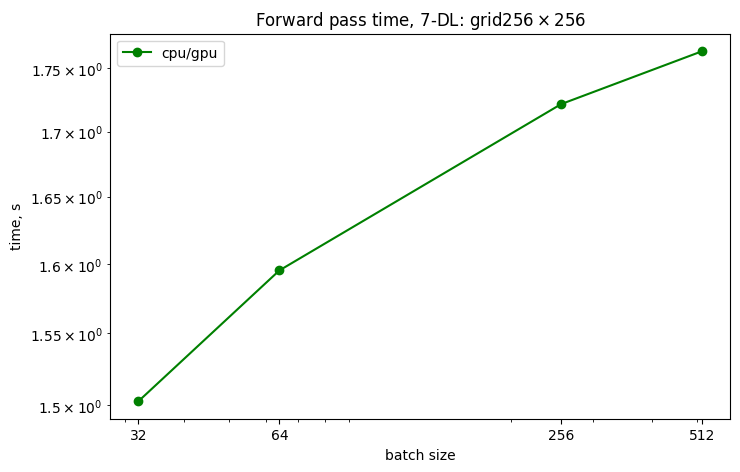

In [216]:
plt.figure(figsize=(8, 5))
plt.title('Forward pass time, 7-DL: grid' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
plt.plot(batch_sizes,  np.array(cpu_times[0]) / np.array(gpu_times[0]), '-o', label='cpu/gpu', color="green")
# plt.plot(batch_sizes, , '-o', label='gpu', color="red")
plt.yscale('log')
plt.xscale('log')
plt.xticks(batch_sizes, batch_sizes)
plt.xlabel('batch size')
plt.ylabel('time, s')
plt.legend()

In [ ]:
# print(cpu_times[0])
# print(gpu_times[0])


[634.765625, 593.765625, 603.921875, 628.609375]
[422.421875, 372.171875, 350.78125, 356.390625]


## 4.6 COMPARING CPU AND GPU WITH DIFFERENT GRIDS

In [ ]:
# cpu_times_fs = np.array([1201, 1146, 1147, 1288])
# gpu_times_fs = np.array([404, 377, 368, 354])

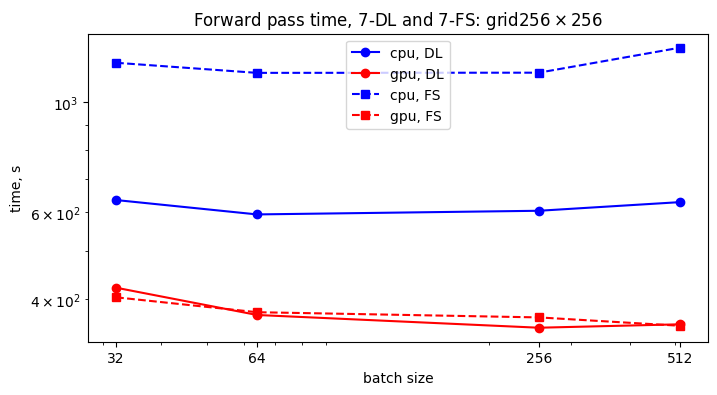

In [ ]:
# plt.figure(figsize=(8, 4))
# plt.title('Forward pass time, 7-DL and 7-FS: grid' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
# plt.plot(batch_sizes, cpu_times[0], '-o', label=r'cpu, DL', color="blue")
# plt.plot(batch_sizes, gpu_times[0], '-o', label=r'gpu, DL', color="red")
# plt.plot(batch_sizes, cpu_times_fs, '--s', label=r'cpu, FS', color="blue")
# plt.plot(batch_sizes, gpu_times_fs, '--s', label=r'gpu, FS', color="red")
# plt.yscale('log')
# plt.xscale('log')
# plt.xticks(batch_sizes, batch_sizes)
# plt.xlabel('batch size')
# plt.ylabel('time, s')
# plt.legend()

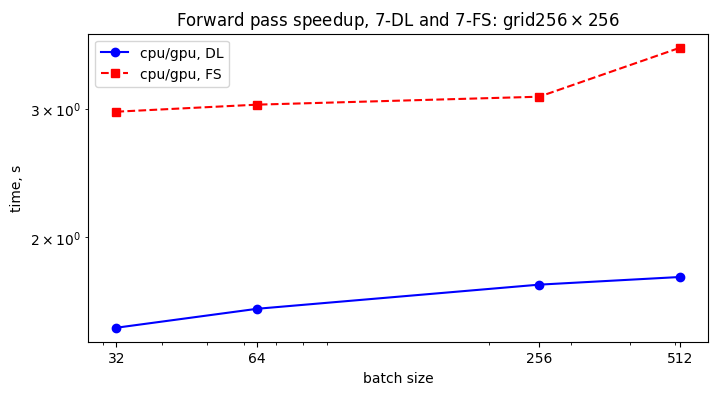

In [ ]:
# plt.figure(figsize=(8, 4))
# plt.title('Forward pass speedup, 7-DL and 7-FS: grid' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
# plt.plot(batch_sizes, np.array(cpu_times[0]) / np.array(gpu_times[0]), '-o', label=r'cpu/gpu, DL', color="blue")
# plt.plot(batch_sizes, cpu_times_fs / gpu_times_fs, '--s', label=r'cpu/gpu, FS', color="red")
# plt.yscale('log')
# plt.xscale('log')
# plt.xticks(batch_sizes, batch_sizes)
# plt.xlabel('batch size')
# plt.ylabel('time, s')
# plt.legend()

In [242]:
params = [
    {
        'pin_memory': True,
        'drop_last': True,
    },
]

cpu_times = {}
gpu_times = {}
gpu_memory = {}
# num_of_layers = [1, 5, 10, 20, 30, 40, 50]
num_of_layers = [1, 5, 10, 20, 25, 30, 40]

for i, param in enumerate(params):
    cpu_times_ = []
    gpu_times_ = []
    gpu_memory_ = []
    cpu_times[i] = cpu_times_
    gpu_times[i] = gpu_times_
    gpu_memory[i] = gpu_memory_
    for layer in num_of_layers:
        train_loader = torch.utils.data.DataLoader(
            train_wf_ds,
            batch_size=64,
            **param

        )

        start = time.process_time()
        SIM_PARAMS = SIM_PARAMS.to('cpu')
        optical_setup = get_setup_upd(layer)
        net = optical_setup.net.to('cpu')
        onn_forward(
            net,  # optical network composed in 3.
            train_loader,  # dataloader of training set
            device='cpu',
            show_process=True,
        )
        cpu_times_.append(time.process_time() - start)

        start = time.process_time()
        SIM_PARAMS = SIM_PARAMS.to('cuda')

        optical_setup = get_setup_upd(layer)
        net = optical_setup.net.to('cuda')

        onn_forward(
            net,  # optical network composed in 3.
            train_loader,  # dataloader of training set
            device='cuda',
            show_process=True,
        )
        gpu_times_.append(time.process_time() - start)
        gpu_memory_.append(torch.cuda.memory_allocated(device=torch.device('cuda')))
        torch.cuda.empty_cache()

validation: 100%|██████████| 859/859 [03:47<00:00,  3.77it/s]


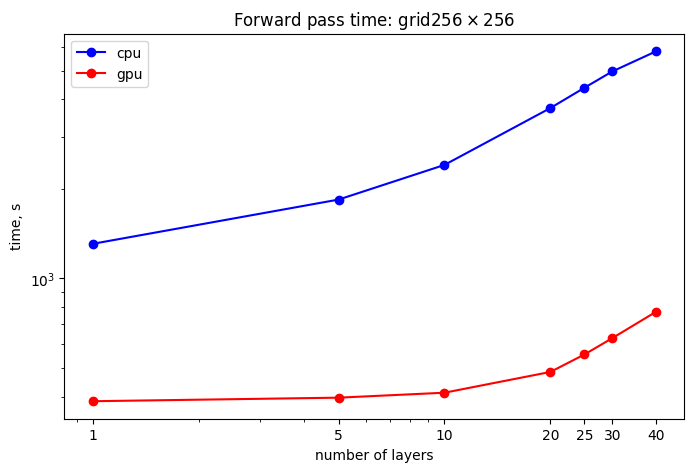

In [243]:
plt.figure(figsize=(8, 5))
plt.title('Forward pass time: grid' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
plt.plot(num_of_layers, cpu_times[0], '-o', label='cpu', color="blue")
plt.plot(num_of_layers, gpu_times[0], '-o', label='gpu', color="red")
plt.yscale('log')
plt.xscale('log')
plt.xticks(num_of_layers, num_of_layers)
plt.xlabel('number of layers')
plt.ylabel('time, s')
plt.legend()

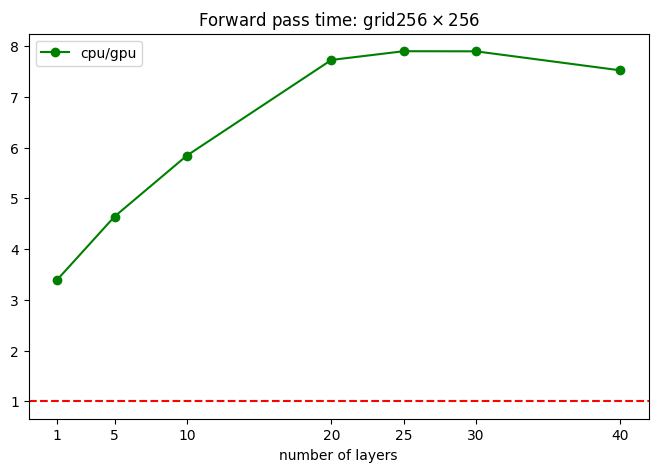

In [247]:
plt.figure(figsize=(8, 5))
plt.title('Forward pass time: grid' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
plt.plot(num_of_layers,  np.array(cpu_times[0]) / np.array(gpu_times[0]), '-o', label='cpu/gpu', color="green")
# plt.yscale('log')
# plt.xscale('log')
plt.xticks(num_of_layers, num_of_layers)
plt.xlabel('number of layers')
# plt.ylabel('time, s')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()

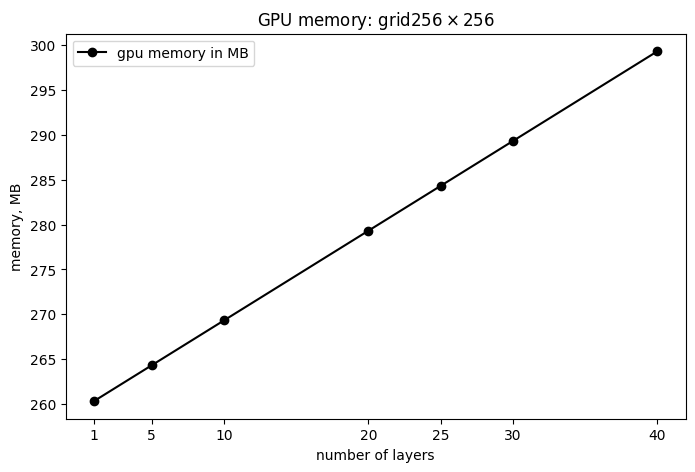

In [245]:
plt.figure(figsize=(8, 5))
plt.title('GPU memory: grid' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
plt.plot(num_of_layers, np.array(gpu_memory[0]) / (1024 ** 2), '-o', label='gpu memory in MB', color="black")
# plt.yscale('log')
# plt.xscale('log')
plt.xticks(num_of_layers, num_of_layers)
plt.xlabel('number of layers')
plt.ylabel('memory, MB')
plt.legend()